# FIT5201 Data analysis algorithms S1 2019 
# Assignment 1
#### Student Name: Nisheeth Shah
#### Student ID: 29599644
#### Email Id: nsha0020@student.monash.edu

Date: 04/04/2019

Environment: R version 3.4.3. <br>
Libraries used:
- reshape2
- ggplot2
- mvtnorm

# Section G. Logistic Regression vs. Bayesian Classifier
## Question 9

### Importing libraries

In [26]:
library(ggplot2)
library(mvtnorm)
library(reshape2)

### I. Read train and test datasets

In [28]:
train <- read.csv(file = "Task2D_train.csv",head=TRUE,sep=",")
test <- read.csv(file = "Task2D_test.csv",head=TRUE,sep=",") 

## Split data to train and labels
train.data = train[-3]
test.data = test[-3]

train.label = train[,3]
test.label = test[,3]

c0 <- '1'; c1 <- '-1' # class labels

### Bayesian Classifier

In [29]:
bayesian_classifier <- function(train.data, train.label, test.label, test.data){
    # Class probabilities:
    p0.hat <- sum(train.label==c0)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])

    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)

    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    test.error <- sum(test.label != test.predict)/nrow(test.data)*100
}

### Logistic Regression

In [30]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [31]:
logistic_regression <- function(train.data, train.label, test.label, test.data){
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE
    
    train.len <- nrow(train.data)
    
    # Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost:
        costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.999
    }
}
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    
    w <- W[tau,]
    
    # calculate predictions:
    test.predict <- predict(w, test.data, c0, c1)

    test.error <- sum(test.label != test.predict)/nrow(test.data)*100
    
   }

### II. Using the first 5 data points from the training set, train a BC and a LR model, and compute their test errors

In [32]:
# For loop to increase the size of training set (5 data points at a time) and calculate test errors for both 
# Bayesian Classifier and Logistic Regression models until all training
sample_seq = seq(from = 5, to = nrow(train), by = 5)
er_test = matrix(0, nrow = length(sample_seq), ncol = 3) # empty matrix to store test errors for Bayesian Classifier

colnames(er_test) = c('train.size', 'test.errors.BC', 'test.errors.LR')
mat_index = 1 # matrix index to store test errors
for (size in sample_seq){
   
    er_test[mat_index, 1] = size
    er_test[mat_index, 2] = bayesian_classifier(train.data[1:size,], train.label[1:size], test.label, test.data)
    er_test[mat_index, 3] = logistic_regression(train.data[1:size,], train.label[1:size], test.label, test.data)
    mat_index = mat_index + 1    

}


### Plot test errors for both Bayesian Classifier and Logistic Regression models

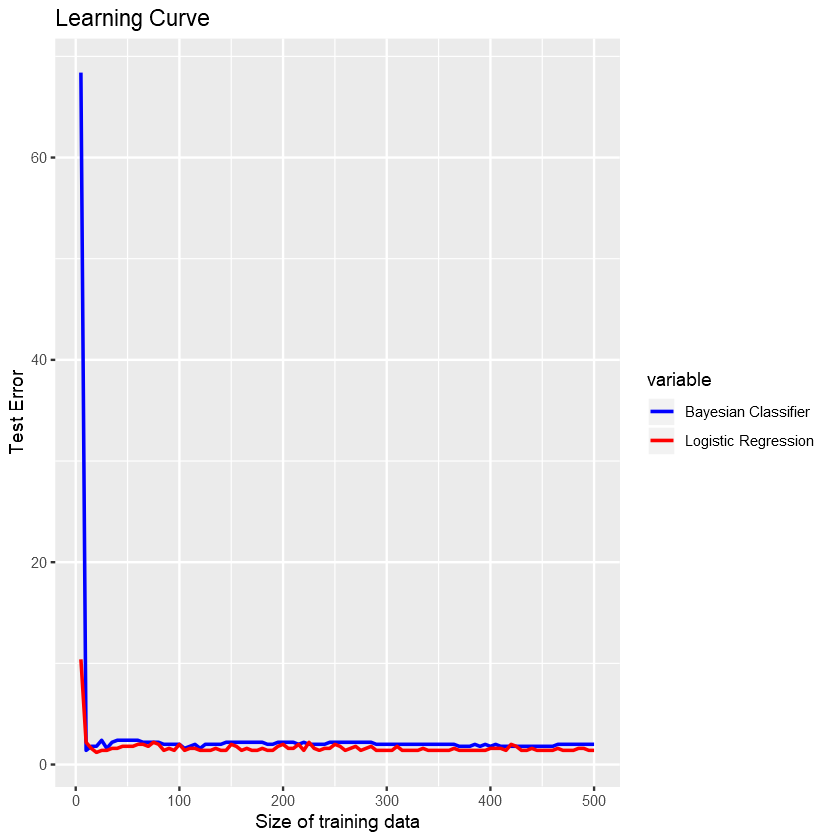

In [33]:
er_test.m <- melt(as.data.frame(er_test), id='train.size')
ggplot(data=er_test.m, aes(x = train.size, y = value, color=variable)) + 
    geom_line(size=.75) + 
    labs(title='Learning Curve', x = "Size of training data", y = "Test Error") +  
    scale_color_manual(labels = c("Bayesian Classifier", "Logistic Regression"), values = c("blue", "red"))


### III: Observations
    a. As the training data size increases (from 5 to 30), test error decreases rapidly from around 70 to 2. After certain size (more than 30), error for both Bayesian Classifier and Logistic Regression fluctautes around 3. We can say, the more sample size, error remains low.
     
    b. From above graph, we can say that Logistic regression is best suited for small and big training set because test error for LR is low than BC.
    
    c. BC works well when variables are independent. However, in our case, the variables might be dependent and therefore, LR is better than BC. This can be possible reason.